<a href="https://colab.research.google.com/github/AyusheeMittal/eva5utils/blob/master/QuizDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime 
print("Current Date and Time: ", datetime.now())

Current Date and Time:  2020-09-26 20:35:35.660481


In [ ]:
!git clone https://github.com/smitasasindran/eva5utils.git

fatal: destination path 'eva5utils' already exists and is not an empty directory.


In [ ]:
%cd eva5utils
!ls
from eva5utils.dataloaders import load_cifar10
from eva5utils.model import Model7, ResNet18
from eva5utils.transforms import model7_transforms
from eva5utils.train import train_loop
from eva5utils.test import test_loop
from eva5utils.utils import plot_samples
from eva5utils.utils.helpers import show_model_summary, DEVICE, IS_CUDA, accuracy_per_class

/content/eva5utils
data  eva5utils  README.md  requirements.txt  setup.py


In [ ]:
# Constants, put in config
epochs = 10
cuda_batch_size=128
cpu_batch_size = 4
num_workers = 4

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
 
class Model(nn.Module):
    def __init__(self):
      super(Model, self).__init__()
 
      self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), padding=1, stride=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64)
        )
      
      self.shortcut1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(1,1), padding=0, stride=1, bias=False),
        nn.BatchNorm2d(64)
        )
 
      self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1, stride=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64)
        )
      
      self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1, stride=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(128)
        )
      
      self.shortcut2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,1), padding=0, stride=1, bias=False),
        nn.BatchNorm2d(128)
        )
      
      self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding=1, stride=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(128)
        )
      
      self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1, stride=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(256)
        )
      
      self.shortcut3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,1), padding=0, stride=1, bias=False),
        nn.BatchNorm2d(256)
        )
      
      self.conv6 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=1, stride=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(256)
        )
      
      self.conv7 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), padding=1, stride=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(512)
        )
      
      self.shortcut4 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,1), padding=0, stride=1, bias=False),
        nn.BatchNorm2d(512)
        )
      
      self.conv8 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), padding=1, stride=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(512)
        )
      
      self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=7)
        ) 
 
      self.fc = nn.Linear(1 * 1 * 512, 10)
      self.pool = nn.MaxPool2d(2, 2)
 
    def forward(self, x1):                                   #x1         32              3
      x2 = self.conv1(x1)                                    #x2         padding 32      3-64
      out = x2 + self.shortcut1(x1)                           #x1+x2      32              64
      x3 = self.conv2(out)                                   #x3         padding 32      64-64
      out = x3 + x2 + self.shortcut1(x1)                      #x1+x2+x3   32              64
      x4 = self.pool(out)                                    #x4         pool 16         64
      x5 = self.conv3(x4)                                    #x5         padding 16      64-128
      out = x5 + self.shortcut2(x4)                          #x4+x5      16              128
      x6 = self.conv4(out)                                   #x6         padding 16      128-128
      out = x6 + x5 + self.shortcut2(x4)                     #x4+x5+x6   16              128                      
      x7 = self.conv5(out)                                   #x7         padding 16      128-256
      out = x7 + self.shortcut3(x6) + self.shortcut3(x5)     #x5+x6+x7   16              256
      x8 = self.pool(out)                                    #x8         pool 8          256
      x9 = self.conv6(x8)                                    #x9         padding 8       256-256
      out = x8 + x9                                          #x8+x9      8               256              
      x10 = self.conv7(out)                                  #x10        padding 8       256-512
      out = x10 + self.shortcut4(x9) + self.shortcut4(x8)    #x8+x9+x10  8               512
      x11 = self.conv8(out)                                  #x11        no padding 6    512-512
      x12 = self.gap(x11)                                    #x12        1               512
      out = x12.view(-1, 1 * 1 * 512)
      x13 = self.fc(out)                                     #x13        1               512-10      
      return x13
 
model1 = Model()
show_model_summary(model1.to(DEVICE), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]             192
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          36,864
              ReLU-7           [-1, 64, 32, 32]               0
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]             192
      BatchNorm2d-10           [-1, 64, 32, 32]             128
        MaxPool2d-11           [-1, 64, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]          73,728
             ReLU-13          [-1, 128, 16, 16]               0
      BatchNorm2d-14          [-1, 128,

In [ ]:
transforms = model7_transforms()
(trainloader, testloader, classes) = load_cifar10(transforms, transforms, cuda_batch_size, cpu_batch_size, num_workers)

Files already downloaded and verified
Files already downloaded and verified


[1,   391] loss: 569.811
[2,   391] loss: 370.035
[3,   391] loss: 285.283
[4,   391] loss: 230.600
[5,   391] loss: 197.246
[6,   391] loss: 170.297
[7,   391] loss: 151.282
[8,   391] loss: 134.717
[9,   391] loss: 118.960
[10,   391] loss: 107.757


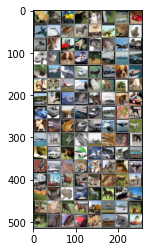

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=30, gamma=.1)
plot_samples(trainloader)

train_loop(epochs, trainloader, model1, DEVICE, optimizer, criterion, scheduler)

In [ ]:
test_loop(testloader, model1, DEVICE, criterion)
accuracy_per_class(model1, classes, testloader, DEVICE)

Accuracy of the network on the 10000 test images: 86 %, Test loss: 1341.4171681404114
Accuracy of plane : 93 %
Accuracy of   car : 85 %
Accuracy of  bird : 88 %
Accuracy of   cat : 66 %
Accuracy of  deer : 91 %
Accuracy of   dog : 79 %
Accuracy of  frog : 83 %
Accuracy of horse : 81 %
Accuracy of  ship : 96 %
Accuracy of truck : 95 %
